# Setting the environment




In [1]:
#@title
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [42]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 25.51GB
Available: 23.99GB
Used: 2.11GB
Percentage: 6.0%


In [43]:
! nvidia-smi

Tue Feb  2 22:08:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [44]:
# importing python utility libraries
import os, sys, random, io, urllib
from datetime import datetime

# importing pytorch libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

# importing data science libraries
import pandas as pd
import random as rd
import numpy as np

# importing python plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
from IPython.display import Image, display

In [45]:
# print current Python version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The Python version: {}'.format(now, sys.version))

[LOG 20210202-22:08:57] The Python version: 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]


In [46]:
# print current PyTorch version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The PyTorch version: {}'.format(now, torch.__version__))

[LOG 20210202-22:09:00] The PyTorch version: 1.7.0+cu101


#Data Preparation Workflow

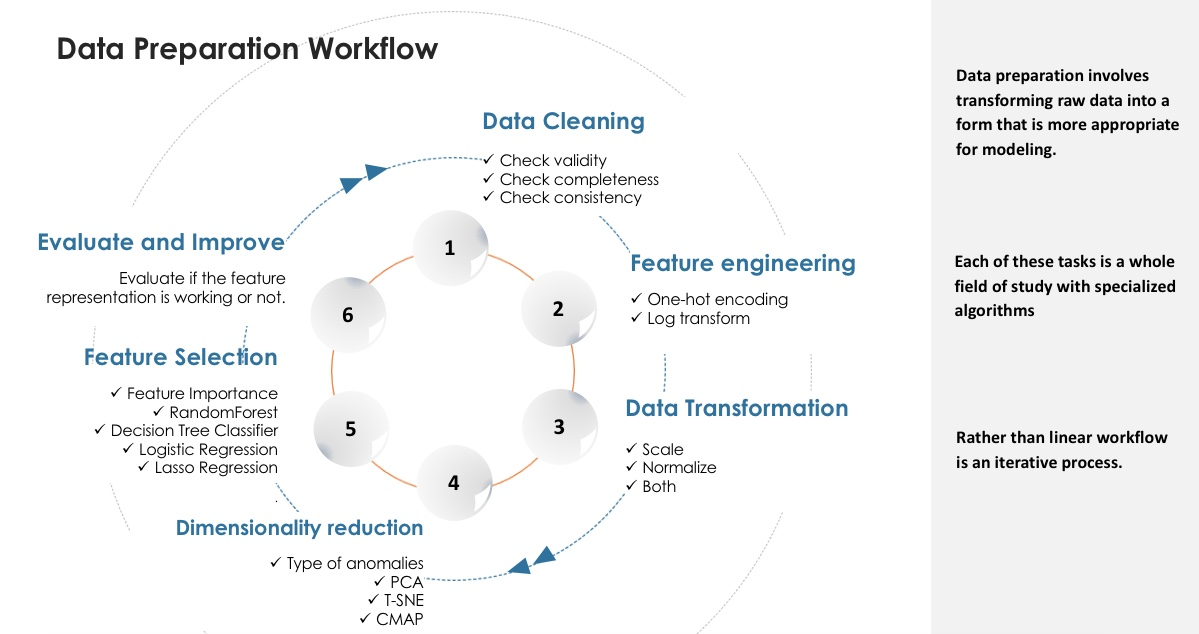

#Dataset Quality and Data cleaning


1.   **Validity**

**Problem**: Detecting fraud on Accounting Information Systems

**Database A**: Records on Accounting Information Systems


The database record the information flow from an incoming voice to an outgoing payment, technical journal entries are recorded in designated database tables.

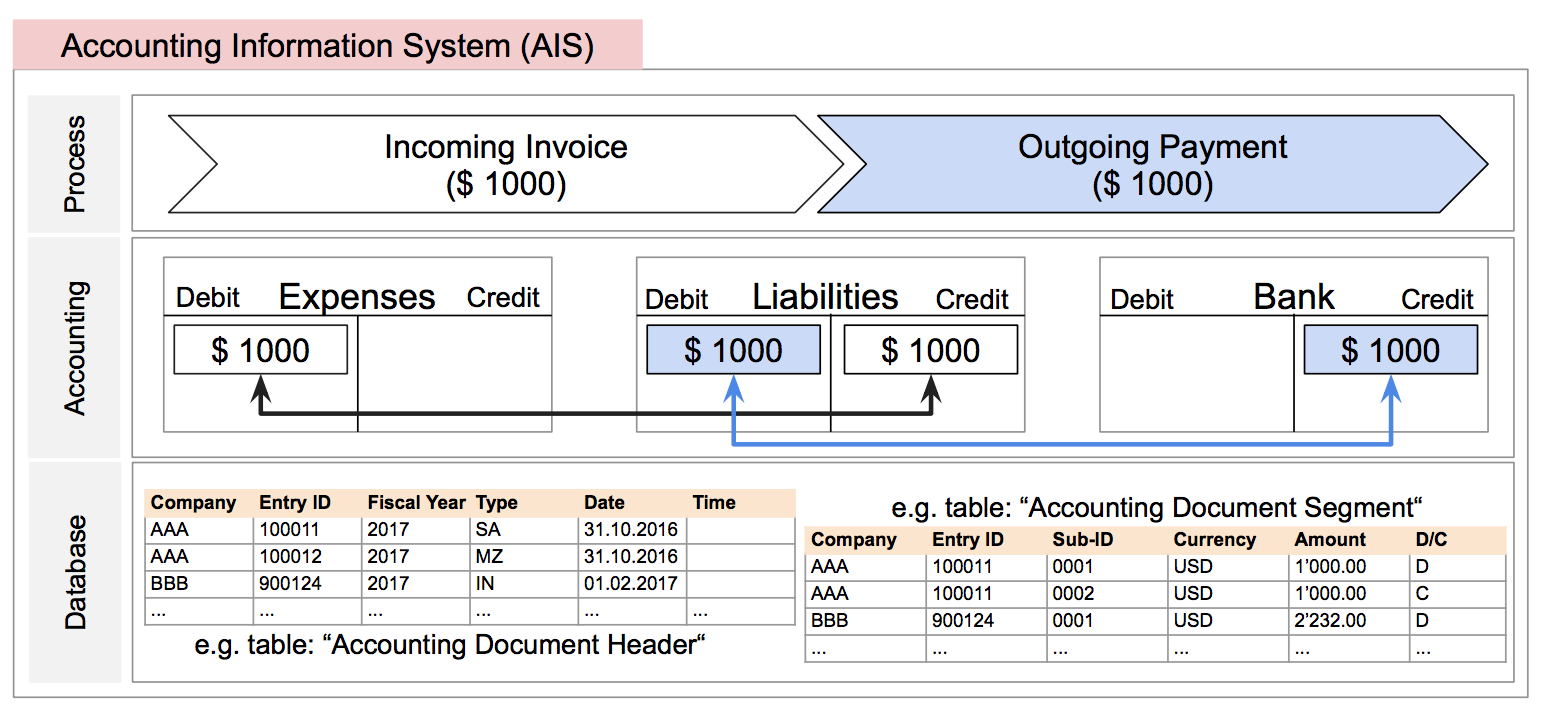

In [48]:
#load the synthetic ERP dataset
ori_dataset = pd.read_csv('/content/gdrive/My Drive/dataset journal entries/fraud_dataset_v2.csv')
ori_dataset

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular
...,...,...,...,...,...,...,...,...,...,...
533004,446818,C1,C18,C3,C32,A1,B2,2501589.15,0.00,regular
533005,455564,C8,C80,C1,C11,A1,B1,390076.18,12065.45,regular
533006,156896,C1,C10,C1,C19,A1,B1,192147.38,326823.09,regular
533007,455245,C1,C14,C4,C40,A1,B3,870539.68,0.00,regular


1.  BELNR: the accounting document number
2.   WAERS: the currency key
3.   BUKRS: the company code
4.   KTOSL: the general ledger account key
5.   PRCTR: the posted profit center
6.   BSCHL: the posting key
7.   HKONT: the posted general ledger account
8.   DMBTR: the amount in local currency
9.   WRBTR: the amount in document currency

**2.   Check completness**

In [49]:
ori_dataset.isnull().values.any().sum()

0

In [50]:
# inspect top rows of the ERP dataset
ori_dataset.head(10) 

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular
5,327203,C1,C15,C6,C68,A1,B2,357627.56,704520.00,regular
6,292545,C4,C47,C2,C28,A2,B3,955576.84,128328.00,regular
7,335839,C1,C19,C1,C17,A1,B1,41769.26,0.00,regular
8,369064,C4,C40,C9,C97,A2,B1,44309.79,0.00,regular
9,138724,C6,C69,C1,C12,A2,B1,466720.45,43843.00,regular


3.   **Consistency (Unbalanced dataset)**

In [51]:
# number of anomalies vs. regular transactions
ori_dataset.label.value_counts()

regular    532909
global         70
local          30
Name: label, dtype: int64

Similar to real world scenarios, we are facing a highly "unbalanced" dataset. Overall, the dataset contains only a small fraction of 100 (0.018%) anomalous transactions. While the 100 anomalous entries encompass 70 (0.013%) "global" anomalies and 30 (0.005%) "local" anomalies

In [16]:
# remove the "ground-truth" label information for the following steps of the lab
label = ori_dataset.pop('label')

In [17]:
label

0         regular
1         regular
2         regular
3         regular
4         regular
           ...   
533004    regular
533005    regular
533006    regular
533007    regular
533008    regular
Name: label, Length: 533009, dtype: object

#Feature Engineering

**1.   One Hot encoding**



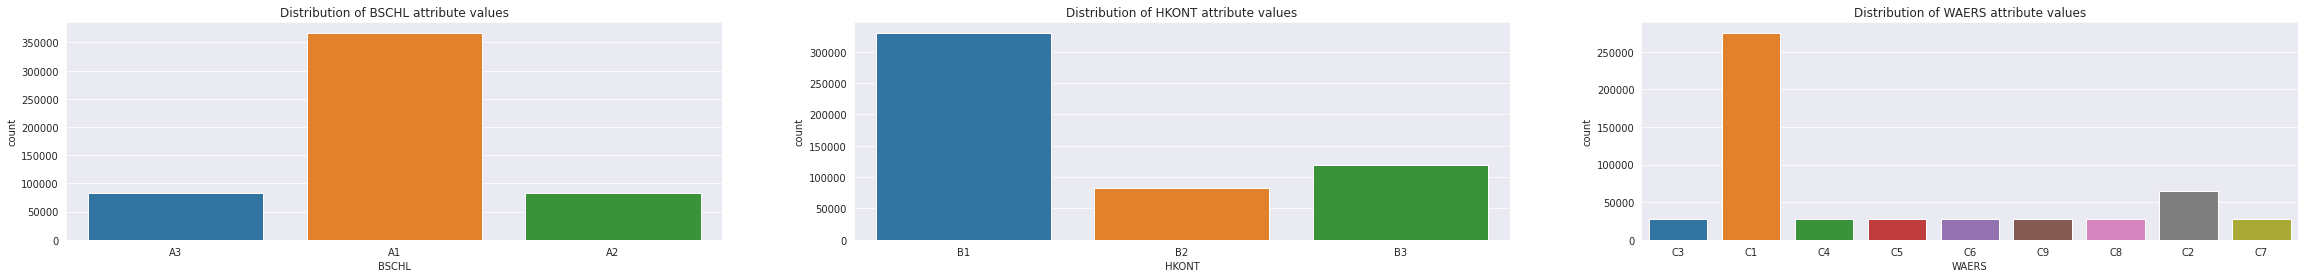

In [52]:
# prepare to plot posting key and general ledger account side by side
fig, ax = plt.subplots(1,3)
fig.set_figwidth(40)

# plot the distribution of the posting key attribute
g = sns.countplot(x=ori_dataset.loc[label=='regular', 'BSCHL'], ax=ax[0])
g.set_xticklabels(g.get_xticklabels(), rotation=0)
g.set_title('Distribution of BSCHL attribute values')

# plot the distribution of the general ledger account attribute
g = sns.countplot(x=ori_dataset.loc[label=='regular', 'HKONT'], ax=ax[1])
g.set_xticklabels(g.get_xticklabels(), rotation=0)
g.set_title('Distribution of HKONT attribute values');

# plot the distribution of the general ledger account attribute
g = sns.countplot(x=ori_dataset.loc[label=='regular', 'WAERS'], ax=ax[2])
g.set_xticklabels(g.get_xticklabels(), rotation=0)
g.set_title('Distribution of WAERS attribute values');

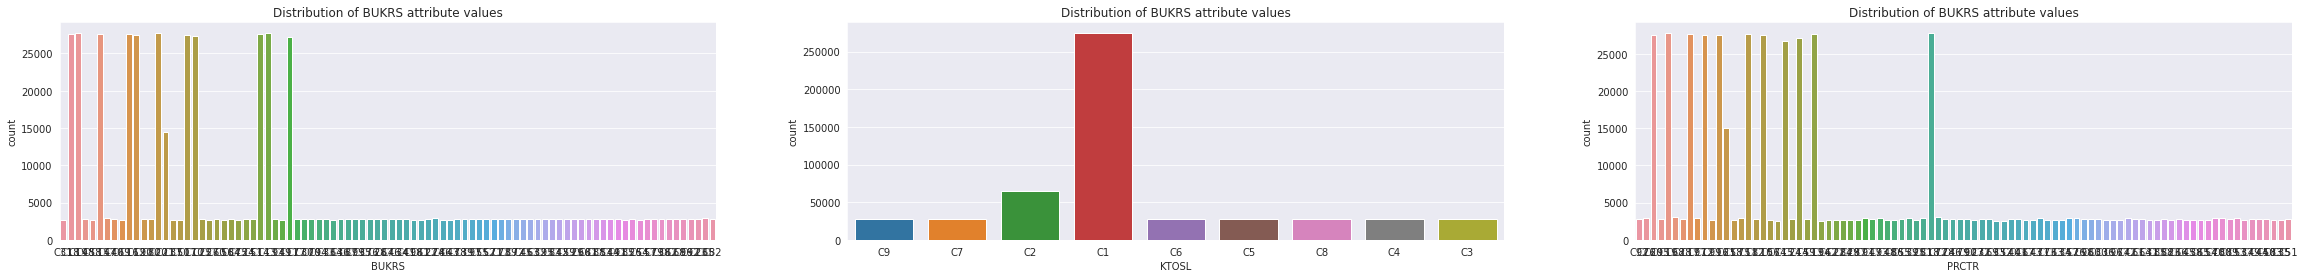

In [53]:
# prepare to plot posting key and general ledger account side by side
fig, ax = plt.subplots(1,3)
fig.set_figwidth(40)

# plot the distribution of the general ledger account attribute
g = sns.countplot(x=ori_dataset.loc[label=='regular', 'BUKRS'], ax=ax[0])
g.set_xticklabels(g.get_xticklabels(), rotation=0)
g.set_title('Distribution of BUKRS attribute values');

# plot the distribution of the general ledger account attribute
g = sns.countplot(x=ori_dataset.loc[label=='regular', 'KTOSL'], ax=ax[1])
g.set_xticklabels(g.get_xticklabels(), rotation=0)
g.set_title('Distribution of BUKRS attribute values');

# plot the distribution of the general ledger account attribute
g = sns.countplot(x=ori_dataset.loc[label=='regular', 'PRCTR'], ax=ax[2])
g.set_xticklabels(g.get_xticklabels(), rotation=0)
g.set_title('Distribution of BUKRS attribute values');

In [54]:
ori_dataset

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular
...,...,...,...,...,...,...,...,...,...,...
533004,446818,C1,C18,C3,C32,A1,B2,2501589.15,0.00,regular
533005,455564,C8,C80,C1,C11,A1,B1,390076.18,12065.45,regular
533006,156896,C1,C10,C1,C19,A1,B1,192147.38,326823.09,regular
533007,455245,C1,C14,C4,C40,A1,B3,870539.68,0.00,regular


In [55]:
labels_rob = ori_dataset['label']
type(labels_rob)

pandas.core.series.Series

In [56]:
# select categorical attributes to be "one-hot" encoded
categorical_attr_names = ['KTOSL', 'PRCTR', 'BSCHL', 'HKONT', 'BUKRS', 'WAERS', 'label']
#categorical_attr_names = ['KTOSL', 'PRCTR', 'BSCHL', 'HKONT', 'BUKRS', 'WAERS']

# encode categorical attributes into a binary one-hot encoded representation 
ori_dataset_categ_transformed = pd.get_dummies(ori_dataset[categorical_attr_names])

In [155]:
ori_dataset_categ_transformed

,KTOSL_A19,KTOSL_B06,KTOSL_B12,KTOSL_B83,KTOSL_C1,KTOSL_C2,KTOSL_C3,KTOSL_C39,KTOSL_C4,KTOSL_C5,KTOSL_C6,KTOSL_C7,KTOSL_C76,KTOSL_C8,KTOSL_C84,KTOSL_C9,KTOSL_D30,KTOSL_D51,KTOSL_D84,KTOSL_D89,KTOSL_E35,KTOSL_E40,KTOSL_F19,KTOSL_F45,KTOSL_G09,KTOSL_G19,KTOSL_G28,KTOSL_I08,KTOSL_I94,KTOSL_J33,KTOSL_J53,KTOSL_J67,KTOSL_J81,KTOSL_K00,KTOSL_K78,KTOSL_K80,KTOSL_K84,KTOSL_L07,KTOSL_L09,KTOSL_L17,...,WAERS_L47,WAERS_L82,WAERS_M07,WAERS_N09,WAERS_N15,WAERS_N43,WAERS_O37,WAERS_O43,WAERS_O64,WAERS_O67,WAERS_P03,WAERS_P31,WAERS_P36,WAERS_P37,WAERS_P79,WAERS_Q52,WAERS_Q82,WAERS_R07,WAERS_R09,WAERS_S05,WAERS_S12,WAERS_S31,WAERS_T17,WAERS_T28,WAERS_T65,WAERS_T68,WAERS_T87,WAERS_U72,WAERS_U94,WAERS_V89,WAERS_W25,WAERS_W59,WAERS_X26,WAERS_Y59,WAERS_Z06,WAERS_Z37,WAERS_Z54,label_global,label_local,label_regular
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533004,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
533005,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
533006,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
533007,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


**2.   Log Transformation quantitative variables**

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


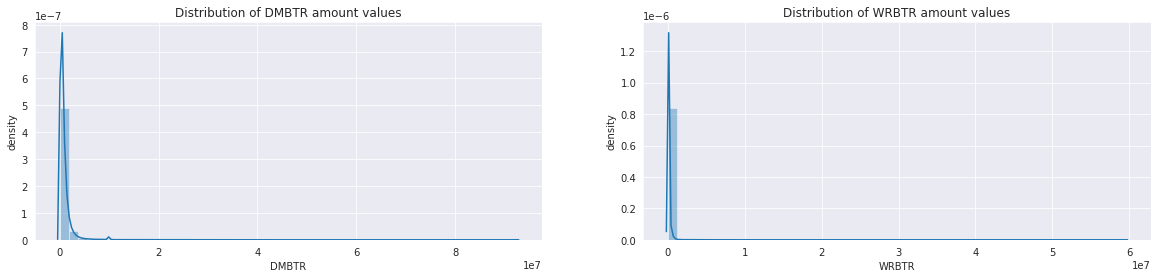

In [58]:
# init the plots
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot distribution of the local amount attribute
g = sns.distplot(ori_dataset['DMBTR'].tolist(), ax=ax[0])
g.set_title('Distribution of DMBTR amount values')

# set axis-labels 
ax[0].set_xlabel('DMBTR')
ax[0].set_ylabel('density')

# plot distribution of the document amount attribute
g = sns.distplot(ori_dataset['WRBTR'].tolist(), ax=ax[1])
g.set_title('Distribution of WRBTR amount values')

# set axis-labels
ax[1].set_xlabel('WRBTR')
ax[1].set_ylabel('density');

In [59]:
# select "DMBTR" vs. "WRBTR" attribute
numeric_attr_names = ['DMBTR', 'WRBTR']

# add a small epsilon to eliminate zero values from data for log scaling
numeric_attr = ori_dataset[numeric_attr_names] + 1e-4
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attributes to the range [0,1]
ori_dataset_numeric_attr = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

#Data Transformation

**1.   Scaling**




In [60]:
from sklearn.preprocessing import StandardScaler
ori_dataset_numeric_attr_std_scaler = StandardScaler().fit_transform(ori_dataset[numeric_attr_names])
ori_dataset_numeric_attr_std_scaler

array([[-0.29814245, -0.07670041],
       [-0.3683575 ,  0.22308289],
       [ 0.01616683,  3.84558867],
       ...,
       [-0.33941582,  0.32592512],
       [-0.02422007, -0.07670041],
       [-0.18146328, -0.036703  ]])

In [61]:
ori_dataset_numeric_attr_std_scaler_df = pd.DataFrame(data = ori_dataset_numeric_attr_std_scaler)

In [62]:
ori_dataset_numeric_attr_std_scaler_df 

,0,1
0,-0.298142,-0.076700
1,-0.368357,0.223083
2,0.016167,3.845589
3,0.817289,-0.041248
4,-0.005647,-0.076274
...,...,...
533004,0.733601,-0.076700
533005,-0.247454,-0.061837
533006,-0.339416,0.325925
533007,-0.024220,-0.076700


In [63]:
ori_dataset_numeric_attr_std_scaler_df.columns = ['DMBTR','WRBTR']
ori_dataset_numeric_attr_std_scaler_df

,DMBTR,WRBTR
0,-0.298142,-0.076700
1,-0.368357,0.223083
2,0.016167,3.845589
3,0.817289,-0.041248
4,-0.005647,-0.076274
...,...,...
533004,0.733601,-0.076700
533005,-0.247454,-0.061837
533006,-0.339416,0.325925
533007,-0.024220,-0.076700


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


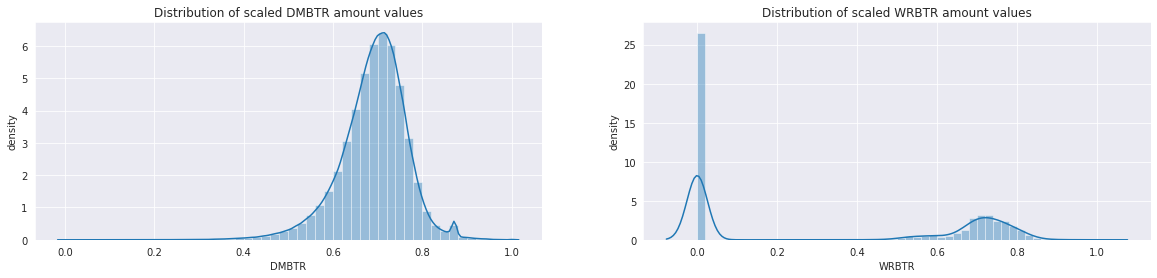

In [64]:
# init the plots
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot distribution of the local amount attribute
g = sns.distplot(ori_dataset_numeric_attr['DMBTR'].tolist(), ax=ax[0])
g.set_title('Distribution of scaled DMBTR amount values')

# set axis-labels 
ax[0].set_xlabel('DMBTR')
ax[0].set_ylabel('density')

# plot distribution of the local amount attribute
g = sns.distplot(ori_dataset_numeric_attr['WRBTR'].tolist(), ax=ax[1])
g.set_title('Distribution of scaled WRBTR amount values')

# set axis-labels
ax[1].set_xlabel('WRBTR')
ax[1].set_ylabel('density');

# Dimensionality reduction

**1.   Global and Local Anomalies**

**Global Anomalies**, are financial transactions that exhibit unusual or rare individual attribute values. These anomalies usually relate to highly skewed attributes e.g. seldom posting users, rarely used ledgers, or unusual posting times.

Traditionally "red-flag" tests, performed by auditors during annual audits, are designed to capture those types of anomalies. However, such tests might result in a high volume of false positive alerts due to e.g. regular reverse postings, provisions and year-end adjustments usually associated with a low fraud risk.

**Local Anomalies**, are financial transactions that exhibit an unusual or rare combination of attribute values while the individual attribute values occur quite frequently e.g. unusual accounting records.

This type of anomaly is significantly more difficult to detect since perpetrators intend to disguise their activities trying to imitate a regular behaviour. As a result, such anomalies usually pose a high fraud risk since they might correspond to e.g. misused user accounts, irregular combinations of general ledger accounts and posting keys that don't follow an usual activity pattern.

In [66]:
# merge categorical and numeric subsets
ori_subset_transformed = pd.concat([ori_dataset_categ_transformed, ori_dataset_numeric_attr], axis = 1)

In [154]:
ori_subset_transformed

,KTOSL_A19,KTOSL_B06,KTOSL_B12,KTOSL_B83,KTOSL_C1,KTOSL_C2,KTOSL_C3,KTOSL_C39,KTOSL_C4,KTOSL_C5,KTOSL_C6,KTOSL_C7,KTOSL_C76,KTOSL_C8,KTOSL_C84,KTOSL_C9,KTOSL_D30,KTOSL_D51,KTOSL_D84,KTOSL_D89,KTOSL_E35,KTOSL_E40,KTOSL_F19,KTOSL_F45,KTOSL_G09,KTOSL_G19,KTOSL_G28,KTOSL_I08,KTOSL_I94,KTOSL_J33,KTOSL_J53,KTOSL_J67,KTOSL_J81,KTOSL_K00,KTOSL_K78,KTOSL_K80,KTOSL_K84,KTOSL_L07,KTOSL_L09,KTOSL_L17,...,WAERS_M07,WAERS_N09,WAERS_N15,WAERS_N43,WAERS_O37,WAERS_O43,WAERS_O64,WAERS_O67,WAERS_P03,WAERS_P31,WAERS_P36,WAERS_P37,WAERS_P79,WAERS_Q52,WAERS_Q82,WAERS_R07,WAERS_R09,WAERS_S05,WAERS_S12,WAERS_S31,WAERS_T17,WAERS_T28,WAERS_T65,WAERS_T68,WAERS_T87,WAERS_U72,WAERS_U94,WAERS_V89,WAERS_W25,WAERS_W59,WAERS_X26,WAERS_Y59,WAERS_Z06,WAERS_Z37,WAERS_Z54,label_global,label_local,label_regular,DMBTR,WRBTR
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.666634,0.000000
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.622241,0.797122
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.737149,0.891960
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.796385,0.718383
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.734257,0.555329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533004,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.792386,0.000000
533005,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.685503,0.686323
533006,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.644777,0.808000
533007,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.731675,0.000000


In [68]:
ori_subset_transformed_scaler = pd.concat([ori_dataset_categ_transformed, ori_dataset_numeric_attr_std_scaler_df], axis = 1)
ori_subset_transformed_scaler 

,KTOSL_A19,KTOSL_B06,KTOSL_B12,KTOSL_B83,KTOSL_C1,KTOSL_C2,KTOSL_C3,KTOSL_C39,KTOSL_C4,KTOSL_C5,KTOSL_C6,KTOSL_C7,KTOSL_C76,KTOSL_C8,KTOSL_C84,KTOSL_C9,KTOSL_D30,KTOSL_D51,KTOSL_D84,KTOSL_D89,KTOSL_E35,KTOSL_E40,KTOSL_F19,KTOSL_F45,KTOSL_G09,KTOSL_G19,KTOSL_G28,KTOSL_I08,KTOSL_I94,KTOSL_J33,KTOSL_J53,KTOSL_J67,KTOSL_J81,KTOSL_K00,KTOSL_K78,KTOSL_K80,KTOSL_K84,KTOSL_L07,KTOSL_L09,KTOSL_L17,...,WAERS_M07,WAERS_N09,WAERS_N15,WAERS_N43,WAERS_O37,WAERS_O43,WAERS_O64,WAERS_O67,WAERS_P03,WAERS_P31,WAERS_P36,WAERS_P37,WAERS_P79,WAERS_Q52,WAERS_Q82,WAERS_R07,WAERS_R09,WAERS_S05,WAERS_S12,WAERS_S31,WAERS_T17,WAERS_T28,WAERS_T65,WAERS_T68,WAERS_T87,WAERS_U72,WAERS_U94,WAERS_V89,WAERS_W25,WAERS_W59,WAERS_X26,WAERS_Y59,WAERS_Z06,WAERS_Z37,WAERS_Z54,label_global,label_local,label_regular,DMBTR,WRBTR
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.298142,-0.076700
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.368357,0.223083
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.016167,3.845589
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.817289,-0.041248
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.005647,-0.076274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533004,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.733601,-0.076700
533005,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.247454,-0.061837
533006,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.339416,0.325925
533007,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.024220,-0.076700


In [69]:
ori_subset_transformed_scaler 

,KTOSL_A19,KTOSL_B06,KTOSL_B12,KTOSL_B83,KTOSL_C1,KTOSL_C2,KTOSL_C3,KTOSL_C39,KTOSL_C4,KTOSL_C5,KTOSL_C6,KTOSL_C7,KTOSL_C76,KTOSL_C8,KTOSL_C84,KTOSL_C9,KTOSL_D30,KTOSL_D51,KTOSL_D84,KTOSL_D89,KTOSL_E35,KTOSL_E40,KTOSL_F19,KTOSL_F45,KTOSL_G09,KTOSL_G19,KTOSL_G28,KTOSL_I08,KTOSL_I94,KTOSL_J33,KTOSL_J53,KTOSL_J67,KTOSL_J81,KTOSL_K00,KTOSL_K78,KTOSL_K80,KTOSL_K84,KTOSL_L07,KTOSL_L09,KTOSL_L17,...,WAERS_M07,WAERS_N09,WAERS_N15,WAERS_N43,WAERS_O37,WAERS_O43,WAERS_O64,WAERS_O67,WAERS_P03,WAERS_P31,WAERS_P36,WAERS_P37,WAERS_P79,WAERS_Q52,WAERS_Q82,WAERS_R07,WAERS_R09,WAERS_S05,WAERS_S12,WAERS_S31,WAERS_T17,WAERS_T28,WAERS_T65,WAERS_T68,WAERS_T87,WAERS_U72,WAERS_U94,WAERS_V89,WAERS_W25,WAERS_W59,WAERS_X26,WAERS_Y59,WAERS_Z06,WAERS_Z37,WAERS_Z54,label_global,label_local,label_regular,DMBTR,WRBTR
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.298142,-0.076700
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.368357,0.223083
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.016167,3.845589
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.817289,-0.041248
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.005647,-0.076274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533004,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.733601,-0.076700
533005,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.247454,-0.061837
533006,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.339416,0.325925
533007,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.024220,-0.076700


In [70]:
labels_196_vo = np.where(labels_rob=='regular', '0', '1')
labels_196_vo

array(['0', '0', '0', ..., '0', '0', '0'], dtype='<U1')

In [71]:
labels_196 = pd.DataFrame(labels_196_vo)

In [72]:
labels_196.columns = ['target']
labels_196

,target
0,0
1,0
2,0
3,0
4,0
...,...
533004,0
533005,0
533006,0
533007,0


In [157]:
ori_subset_transformed_scaler.to_csv(r"gdrive/My Drive/DevNet-semi accounting/dataset/ori_subset_transformed_621.csv", index = False, header = True)

In [158]:
ori_subset_transformed_scaler

,KTOSL_A19,KTOSL_B06,KTOSL_B12,KTOSL_B83,KTOSL_C1,KTOSL_C2,KTOSL_C3,KTOSL_C39,KTOSL_C4,KTOSL_C5,KTOSL_C6,KTOSL_C7,KTOSL_C76,KTOSL_C8,KTOSL_C84,KTOSL_C9,KTOSL_D30,KTOSL_D51,KTOSL_D84,KTOSL_D89,KTOSL_E35,KTOSL_E40,KTOSL_F19,KTOSL_F45,KTOSL_G09,KTOSL_G19,KTOSL_G28,KTOSL_I08,KTOSL_I94,KTOSL_J33,KTOSL_J53,KTOSL_J67,KTOSL_J81,KTOSL_K00,KTOSL_K78,KTOSL_K80,KTOSL_K84,KTOSL_L07,KTOSL_L09,KTOSL_L17,...,WAERS_M07,WAERS_N09,WAERS_N15,WAERS_N43,WAERS_O37,WAERS_O43,WAERS_O64,WAERS_O67,WAERS_P03,WAERS_P31,WAERS_P36,WAERS_P37,WAERS_P79,WAERS_Q52,WAERS_Q82,WAERS_R07,WAERS_R09,WAERS_S05,WAERS_S12,WAERS_S31,WAERS_T17,WAERS_T28,WAERS_T65,WAERS_T68,WAERS_T87,WAERS_U72,WAERS_U94,WAERS_V89,WAERS_W25,WAERS_W59,WAERS_X26,WAERS_Y59,WAERS_Z06,WAERS_Z37,WAERS_Z54,label_global,label_local,label_regular,DMBTR,WRBTR
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.298142,-0.076700
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.368357,0.223083
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.016167,3.845589
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.817289,-0.041248
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.005647,-0.076274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533004,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.733601,-0.076700
533005,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.247454,-0.061837
533006,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.339416,0.325925
533007,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.024220,-0.076700


In [159]:
ori_subset_transformed_scaler.shape

(533009, 621)

In [160]:
labels_621 = labels_196

In [161]:
labels_621.shape

(533009, 1)

In [162]:
labels_621.to_csv(r"gdrive/My Drive/DevNet-semi accounting/dataset/labels_621.csv", index = False, header = True)

In [76]:
ori_subset_transformed_scaler.shape

(533009, 621)

In [163]:
# inspect final dimensions of pre-processed transactional data
ori_subset_transformed.shape

(533009, 621)

In [78]:
type(ori_subset_transformed)

pandas.core.frame.DataFrame

In [79]:
type(label)

pandas.core.series.Series

In [80]:
label

0         regular
1         regular
2         regular
3         regular
4         regular
           ...   
533004    regular
533005    regular
533006    regular
533007    regular
533008    regular
Name: label, Length: 533009, dtype: object

In [75]:
ori_subset_transformed.to_csv(r"/content/gdrive/My Drive/ori_subset_transformed.csv", index = False, header = True)

In [76]:
import csv
ori_subset_transformed.to_csv("/content/gdrive/My Drive/ori_subset_transformed.tsv", sep="\t", header=False, index=False, quoting=csv.QUOTE_NONE, quotechar="",  escapechar="\\")

In [77]:
label.to_csv(r"/content/gdrive/My Drive/label.csv", index = False, header = True)

In [78]:
label.to_csv("/content/gdrive/My Drive/label.tsv", sep="\t", header=False, index=False, quoting=csv.QUOTE_NONE, quotechar="",  escapechar="\\")

**1.   PCA**

In [81]:
labels_v = np.where(label=='regular', '0', '1')
labels_v

array(['0', '0', '0', ..., '0', '0', '0'], dtype='<U1')

In [82]:
labels_v.shape

(533009,)

In [83]:
labels_pca = pd.DataFrame(labels_v)

In [84]:
labels_pca 

,0
0,0
1,0
2,0
3,0
4,0
...,...
533004,0
533005,0
533006,0
533007,0


In [85]:
labels_pca.columns = ['target']

In [86]:
type(label)

pandas.core.series.Series

In [85]:
labels_pca.to_csv(r"/content/gdrive/My Drive/labelbin.csv", index = False, header = True)

**Two principal compoents** explain no more than 30% of the variance, however we can visualize between the three types of data objects such as regular (normal samples) and global and local anomalies



In [87]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(ori_subset_transformed_scaler)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

In [88]:
finalDf = pd.concat([principalDf, label], axis = 1)

In [89]:
finalDf

,principal component 1,principal component 2,label
0,-0.255793,-0.087258,regular
1,-0.099584,0.794016,regular
2,2.735621,1.241996,regular
3,0.556749,-0.101112,regular
4,-0.056354,-0.716288,regular
...,...,...,...
533004,0.467018,0.781183,regular
533005,-0.224368,-0.702190,regular
533006,-0.020910,-0.693805,regular
533007,-0.066775,1.013068,regular


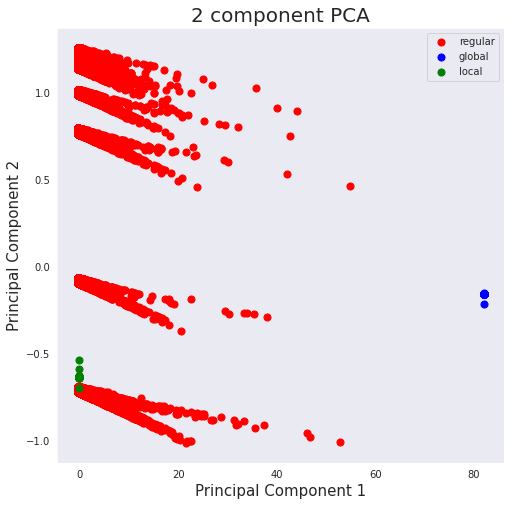

In [90]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['regular', 'global', 'local']
colors = ['r', 'b', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [91]:
from sklearn.decomposition import PCA
pca_69 = PCA(n_components=69)
principalComponents_69 = pca_69.fit_transform(ori_subset_transformed_scaler)

In [92]:
pca.explained_variance_ratio_

array([0.22868452, 0.09931284])

In [93]:
pca_69.explained_variance_ratio_

array([0.22868452, 0.09931284, 0.08631498, 0.08484545, 0.04123221,
       0.03341124, 0.03318027, 0.01794306, 0.01493922, 0.01159022,
       0.00910648, 0.00902251, 0.00900163, 0.00896041, 0.00895192,
       0.0089318 , 0.00891985, 0.00884798, 0.00823103, 0.008213  ,
       0.00820069, 0.00819448, 0.00819143, 0.00817872, 0.00816911,
       0.0081568 , 0.00813955, 0.00813406, 0.00812191, 0.00811623,
       0.00810149, 0.00809057, 0.00806755, 0.0080453 , 0.00800362,
       0.00789688, 0.00584454, 0.00576408, 0.00233465, 0.00233078,
       0.00085822, 0.00085176, 0.0008482 , 0.0008387 , 0.00083593,
       0.00083504, 0.00083408, 0.00083248, 0.00083085, 0.00082993,
       0.00082762, 0.00082658, 0.00082567, 0.00082469, 0.00082336,
       0.00082268, 0.00082171, 0.00082093, 0.00082029, 0.00081867,
       0.000818  , 0.00081657, 0.00081575, 0.00081494, 0.00081379,
       0.00081281, 0.00081162, 0.0008109 , 0.00080995])

In [94]:
pca.explained_variance_

array([1.45306986, 0.63103745])

In [95]:
pca_69.explained_variance_

array([1.45306986, 0.63103745, 0.54844856, 0.53911111, 0.26199098,
       0.21229628, 0.21082868, 0.11401085, 0.09492436, 0.07364467,
       0.0578629 , 0.05732935, 0.0571967 , 0.05693475, 0.05688086,
       0.056753  , 0.05667708, 0.05622037, 0.05230029, 0.05218568,
       0.05210749, 0.05206801, 0.05204866, 0.05196792, 0.05190685,
       0.05182862, 0.05171898, 0.05168414, 0.05160691, 0.05157084,
       0.05147719, 0.05140776, 0.05126148, 0.05112016, 0.05085528,
       0.0501771 , 0.03713643, 0.03662521, 0.01483447, 0.01480989,
       0.00545315, 0.00541209, 0.00538949, 0.00532913, 0.00531152,
       0.00530586, 0.00529978, 0.00528962, 0.00527927, 0.00527342,
       0.00525873, 0.00525209, 0.00524636, 0.00524012, 0.00523164,
       0.00522733, 0.00522118, 0.00521622, 0.00521217, 0.00520188,
       0.0051976 , 0.00518849, 0.00518329, 0.00517816, 0.00517084,
       0.00516462, 0.00515708, 0.0051525 , 0.00514647])

In [96]:
pca.components_

array([[ 1.05799035e-04,  1.05799044e-04,  1.05799045e-04, ...,
        -7.40537095e-03,  7.06925129e-01,  7.07065500e-01],
       [-4.66061485e-07, -4.66061581e-07, -4.66061650e-07, ...,
         8.88535913e-05, -9.55057214e-03, -3.53666061e-03]])

**Cumulative explained variance vs the number of components**

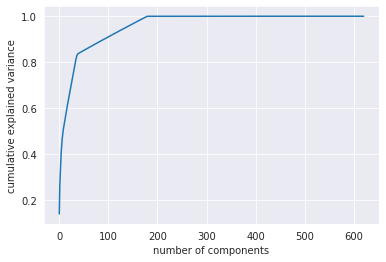

In [97]:
pca_v2 = PCA().fit(ori_subset_transformed)
plt.plot(np.cumsum(pca_v2.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [98]:
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.datasets import load_boston

#boston = load_boston()
df = ori_subset_transformed_scaler
n_components = 5

pca = PCA(n_components=n_components)
components = pca.fit_transform(df)

total_var = pca.explained_variance_ratio_.sum() * 100

labels = {str(i): f"PC {i+1}" for i in range(n_components)}
labels['color'] = 'Median Price'

fig = px.scatter_matrix(
    components,
    color = labels_v,
    dimensions=range(n_components),
    labels=labels,
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [99]:
import plotly.express as px
from sklearn.decomposition import PCA

df = ori_subset_transformed_scaler
X = df

pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=labels_v,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [100]:
labels_pca['target']

0         0
1         0
2         0
3         0
4         0
         ..
533004    0
533005    0
533006    0
533007    0
533008    0
Name: target, Length: 533009, dtype: object

In [100]:
pip install yellowbrick

In [101]:
pip install -U yellowbrick

     |████████████████████████████████| 276kB 5.7MB/s 
  Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


**Three principals components** explain no more than 40% of te variance, however we can visualize between the three types of data objects such as regular (normal samples) and global and local anomalies


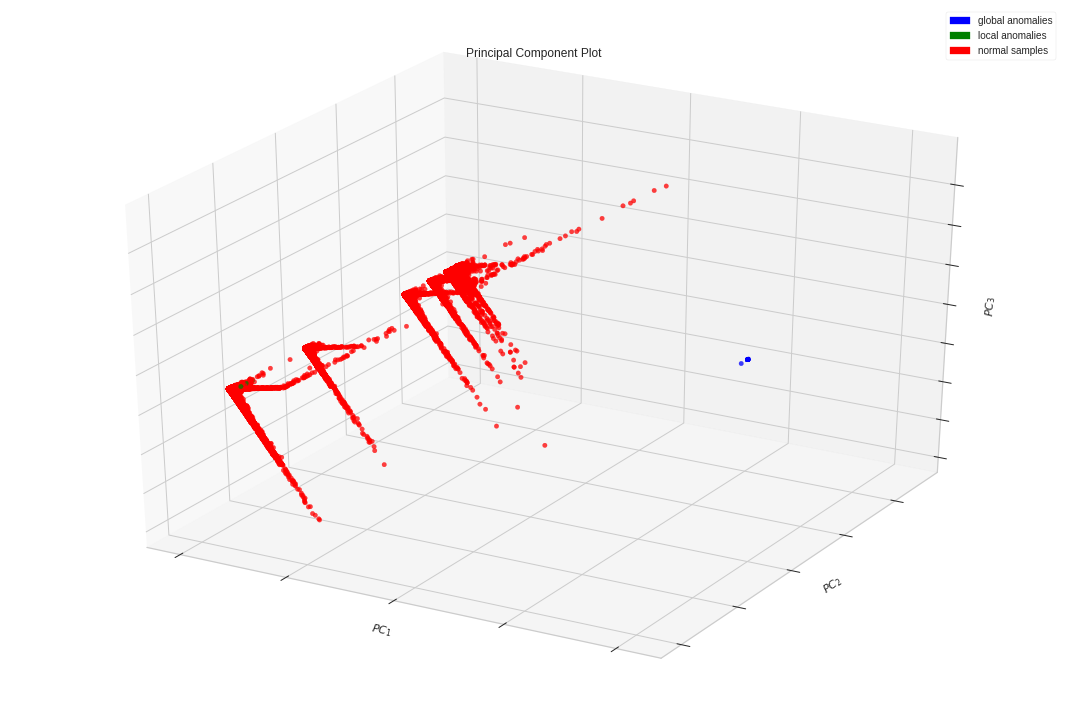

In [102]:
from yellowbrick.datasets import load_credit
from yellowbrick.features import PCA
from sklearn.preprocessing import LabelEncoder
from yellowbrick.style import set_palette
from yellowbrick.features import RadViz

label_encoder = LabelEncoder().fit(label)
y = label_encoder.transform(label)
X=ori_subset_transformed_scaler
#y=labels_pca['target']
classes = ['global anomalies', 'local anomalies', 'normal samples']
visualizer = RadViz(size=(1080, 720))
visualizer = PCA(
    scale=False, projection=3, classes=classes, color=set_palette('reset')
)
visualizer.fit_transform(X, y)
visualizer.show()

In [103]:
label

0         regular
1         regular
2         regular
3         regular
4         regular
           ...   
533004    regular
533005    regular
533006    regular
533007    regular
533008    regular
Name: label, Length: 533009, dtype: object

**T-SNE **

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


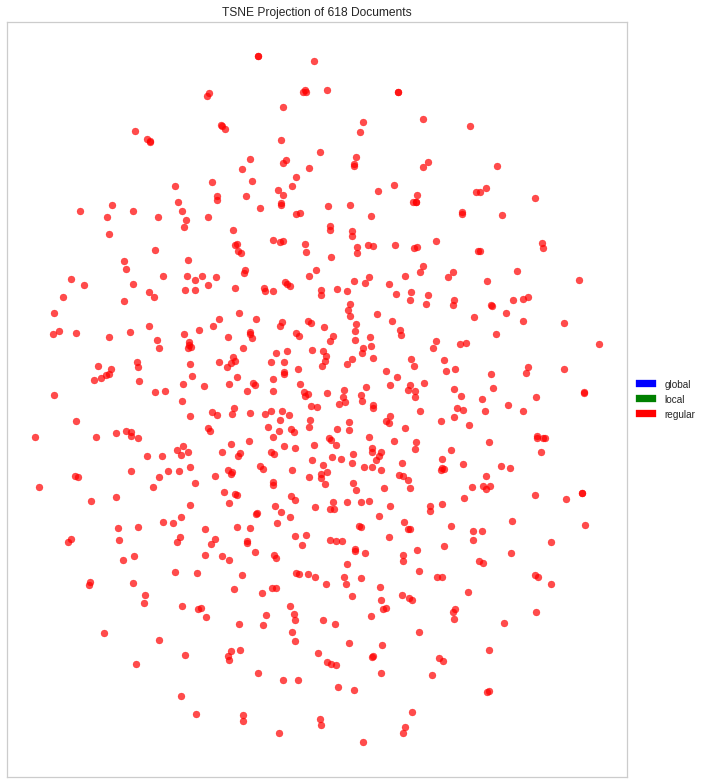

In [104]:
# Import needed packages
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import TSNEVisualizer
from sklearn.preprocessing import LabelEncoder
# Prepare the data
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(ori_subset_transformed_scaler)
#label_encoder = LabelEncoder().fit(label)
#y = label_encoder.transform(label)
# Plot t-SNE
y=label
tsne = TSNEVisualizer(size=(1000,1000))
tsne.fit_transform(X, y)
tsne.poof();

#Feature Selection

**1.   Feature importance by a Decision Tree Classifier**

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

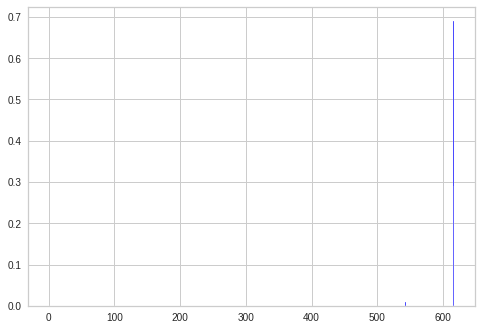

In [105]:
# decision tree for feature importance on a classification problem
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot
# define dataset
X= ori_subset_transformed_scaler
y= labels_pca 
# define the model
model = DecisionTreeClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

**2.   Feature importance by a Random Forest Classifier**


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Feature: 0, Score: 0.00074
Feature: 1, Score: 0.00069
Feature: 2, Score: 0.00024
Feature: 3, Score: 0.00063
Feature: 4, Score: 0.01918
Feature: 5, Score: 0.00029
Feature: 6, Score: 0.00175
Feature: 7, Score: 0.00018
Feature: 8, Score: 0.00076
Feature: 9, Score: 0.00278
Feature: 10, Score: 0.00218
Feature: 11, Score: 0.00365
Feature: 12, Score: 0.00055
Feature: 13, Score: 0.00297
Feature: 14, Score: 0.00208
Feature: 15, Score: 0.00668
Feature: 16, Score: 0.00019
Feature: 17, Score: 0.00043
Feature: 18, Score: 0.00034
Feature: 19, Score: 0.00032
Feature: 20, Score: 0.00054
Feature: 21, Score: 0.00029
Feature: 22, Score: 0.00018
Feature: 23, Score: 0.00078
Feature: 24, Score: 0.00066
Feature: 25, Score: 0.00071
Feature: 26, Score: 0.00102
Feature: 27, Score: 0.00104
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00193
Feature: 30, Score: 0.00032
Feature: 31, Score: 0.00085
Feature: 32, Score: 0.00054
Feature: 33, Score: 0.00095
Feature: 34, Score: 0.00009
Feature: 35, Score: 0.00081
Fe

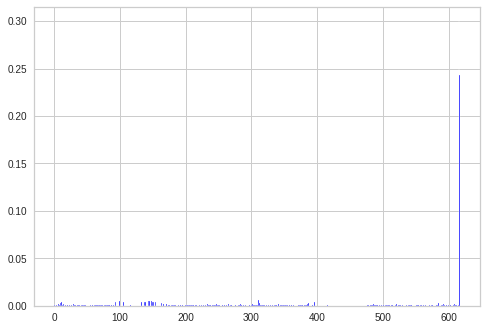

In [106]:
# random forest for feature importance on a classification problem
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
# define dataset
X= ori_subset_transformed_scaler
y= labels_pca 
# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [107]:
!pip install --upgrade xgboost

     |████████████████████████████████| 157.5MB 19kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


**3.   Feature importance by a XGBClassifier**

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[15:43:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.02601
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Fe

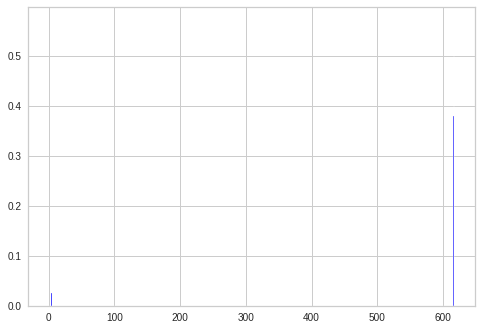

In [108]:
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from matplotlib import pyplot
# define dataset
X= ori_subset_transformed_scaler
y= labels_pca 
# define the model
model = XGBClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

**4.   Feature importance by LogisticRegression**

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Feature: 0, Score: 0.00633
Feature: 1, Score: 0.00633
Feature: 2, Score: 0.00633
Feature: 3, Score: 0.00629
Feature: 4, Score: 3.05119
Feature: 5, Score: -0.50527
Feature: 6, Score: -0.23783
Feature: 7, Score: 0.00633
Feature: 8, Score: -0.16013
Feature: 9, Score: -0.80360
Feature: 10, Score: -0.27443
Feature: 11, Score: -0.31506
Feature: 12, Score: 0.00633
Feature: 13, Score: -0.22327
Feature: 14, Score: 0.00633
Feature: 15, Score: -1.03943
Feature: 16, Score: 0.00633
Feature: 17, Score: 0.00633
Feature: 18, Score: 0.00633
Feature: 19, Score: 0.00633
Feature: 20, Score: 0.00633
Feature: 21, Score: 0.00633
Feature: 22, Score: 0.00633
Feature: 23, Score: 0.00633
Feature: 24, Score: 0.00633
Feature: 25, Score: 0.00633
Feature: 26, Score: 0.00640
Feature: 27, Score: 0.00633
Feature: 28, Score: 0.00633
Feature: 29, Score: 0.00633
Feature: 30, Score: 0.00633
Feature: 31, Score: 0.00633
Feature: 32, Score: 0.00633
Feature: 33, Score: 0.05880
Feature: 34, Score: 0.00633
Feature: 35, Score: 0.

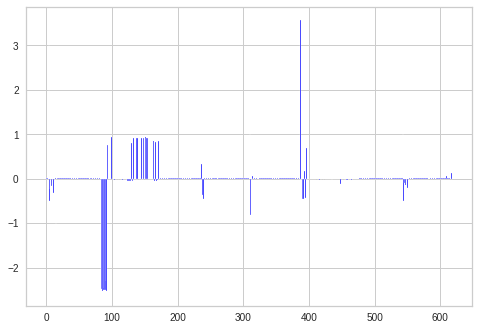

In [109]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
# define dataset
X= ori_subset_transformed_scaler
y= labels_pca 
# define the model
model = LogisticRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
# permutation feature importance with knn for classification
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
# define dataset
X= ori_subset_transformed_scaler
y= labels_pca 
# define the model
model = KNeighborsClassifier()
# fit the model
model.fit(X, y)
# perform permutation importance
results = permutation_importance(model, X, y, scoring='accuracy')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LassoCV
from matplotlib import pyplot
# define dataset
X= ori_subset_transformed_scaler
y= labels_pca 
# define the model
model = LassoCV()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

**5.   Feature importance by Lasso Regression**

In [ ]:
# evaluation of a model using all features
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# define the dataset
X= ori_subset_transformed_scaler
y= labels_pca 
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# fit the model
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 99.99


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
# create ranking among all features by selecting only one
X= ori_subset_transformed_scaler
y= labels_pca 
rfe = RFE(LinearRegression(), n_features_to_select=20)
rfe.fit(X, y)
rfe.ranking_

In [ ]:
from functools import partial
from sklearn.feature_selection import mutual_info_classif, SelectKBest
discrete_feat_idx = [1:616] # an array with indices of discrete features
score_func = partial(mutual_info_classif, discrete_features=discrete_feat_idx)
s = SelectKBest(score_func)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_boston
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

X= ori_subset_transformed_scaler
y= labels_pca 

# We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
clf = LassoCV()

# Set a minimum threshold of 0.25
sfm = SelectFromModel(clf, threshold=0.25)
sfm.fit(X, y)
n_features = sfm.transform(X).shape[1]

# Reset the threshold till the number of features equals two.
# Note that the attribute can be set directly instead of repeatedly
# fitting the metatransformer.
while n_features > 20:
    sfm.threshold += 0.5
    X_transform = sfm.transform(X)
    n_features = X_transform.shape[1]

# Plot the selected two features from X.
plt.title(
    "Features selected from Boston using SelectFromModel with "
    "threshold %0.3f." % sfm.threshold)
feature1 = X_transform[:, 0]
feature2 = X_transform[:, 1] 
plt.plot(feature1, feature2, 'r.')
plt.xlabel("Feature number 1")
plt.ylabel("Feature number 2")
plt.ylim([np.min(feature2), np.max(feature2)])
plt.show()

# Multilayer perceptron network implementation (MLP)

# Semi-supervised

Labeling a few anomalies

In [3]:
import os
import numpy as np

np.random.seed(42)
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
tf.random.set_seed(42)
sess = tf.compat.v1.initialize_all_variables()

from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint

import argparse
import numpy as np
import sys
from scipy.sparse import vstack, csc_matrix
#from utils import dataLoading, aucPerformance, writeResults, get_data_from_svmlight_file
from sklearn.model_selection import train_test_split
#from skmultilearn.model_selection import iterative_train_test_split
from numpy import savetxt, save
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score
import warnings


import time

MAX_INT = np.iinfo(np.int32).max


Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [4]:
def dev_network_d(input_shape):
    '''
    network architecture with three hidden layers 
    '''
    x_input = Input(shape=input_shape)
    intermediate = Dense(1000, activation='relu',
                         kernel_regularizer=regularizers.l2(0.01), name='hl1')(x_input)
    intermediate = Dense(250, activation='relu',
                         kernel_regularizer=regularizers.l2(0.01), name='hl2')(intermediate)
    intermediate = Dense(20, activation='relu',
                         kernel_regularizer=regularizers.l2(0.01), name='hl3')(intermediate)
    intermediate = Dense(1, activation='linear', name='score')(intermediate)
    return Model(x_input, intermediate)

In [5]:
def dev_network_s(input_shape):
    '''
    network architecture with one hidden layer
    '''
    x_input = Input(shape=input_shape)
    intermediate = Dense(20, activation='relu',
                         kernel_regularizer=regularizers.l2(0.01), name='hl1')(x_input)
    intermediate = Dense(1, activation='linear', name='score')(intermediate)
    return Model(x_input, intermediate)

In [6]:
def deviation_network(input_shape, network_depth):
    '''
    construct the deviation network-based detection model
    '''
    if network_depth == 4:
        model = dev_network_d(input_shape)
    elif network_depth == 2:
        model = dev_network_s(input_shape)
    elif network_depth == 1:
        model = dev_network_linear(input_shape)
    else:
        sys.exit("The network depth is not set properly")
    rms = RMSprop(clipnorm=1.)
    model.compile(loss='binary_crossentropy', optimizer=rms)
    return model

In [7]:
def batch_generator_sup(x, outlier_indices, inlier_indices, batch_size, nb_batch, rng):
    """batch generator
    """
    rng = np.random.RandomState(rng.randint(MAX_INT, size=1))
    counter = 0
    while 1:
        ref, training_labels = input_batch_generation_sup(x, outlier_indices, inlier_indices, batch_size, rng)
        counter += 1
        yield (ref, training_labels)
        if (counter > nb_batch):
            counter = 0

In [8]:
def input_batch_generation_sup(x_train, outlier_indices, inlier_indices, batch_size, rng):
    '''
    Alternates between positive and negative pairs.
    '''
    dim = x_train.shape[1]
    ref = np.empty((batch_size, dim))
    training_labels = []
    n_inliers = len(inlier_indices)
    n_outliers = len(outlier_indices)
    for i in range(batch_size):
        if (i % 2 == 0):
            sid = rng.choice(n_inliers, 1)
            ref[i] = x_train[inlier_indices[sid]]
            training_labels += [0]
        else:
            sid = rng.choice(n_outliers, 1)
            ref[i] = x_train[outlier_indices[sid]]
            training_labels += [1]
   
    return np.array(ref), np.array(training_labels)

In [9]:
def load_model_weight_predict(model_name, input_shape, network_depth, x_test):
    '''
    load the saved weights to make predictions
    '''
    model = deviation_network(input_shape, network_depth)
    model.load_weights(model_name)
    scoring_network = Model(inputs=model.input, outputs=model.output)
    scores = scoring_network.predict(x_test)
    
    return scores

In [10]:
import pandas as pd
from sklearn.datasets import load_svmlight_file
from sklearn.externals.joblib import Memory
from sklearn.metrics import average_precision_score, roc_auc_score

def dataLoading(path):
    # loading data
    df = pd.read_csv('../dataset/ori_subset_transformed.csv')
    
    x = df.values

    labels = pd.read_csv('../dataset/labelbin.csv')
    
    print("Data shape: (%d, %d)" % x.shape)

    return x, labels

def aucPerformance(mse, labels):
    roc_auc = roc_auc_score(labels, mse)
    ap = average_precision_score(labels, mse)
    print("AUC-ROC: %.4f, AUC-PR: %.4f" % (roc_auc, ap))
    return roc_auc, ap


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Semi-supervised evaluation

In [12]:
names = ['ori_subset_transformed']
network_depth = 2
random_seed = 42
batch_size=64
nb_batch=30
epochs=50
runs=1
known_outliers=6
input_path = '../dataset'

In [13]:
for nm in names:
    runs = runs
    rauc = np.zeros(runs)
    ap = np.zeros(runs)
    filename = nm.strip()
    x, labels = dataLoading(input_path + filename + ".csv")
    outlier_indices = np.where(labels == 1)[0]
    outliers = x[outlier_indices]
    n_outliers_org = outliers.shape[0]

    train_time = 0
    test_time = 0
    for i in np.arange(runs):
        x_train, x_test, y_train, y_test = train_test_split(x, labels, test_size=0.4, random_state=42,stratify=labels)
        y_train = np.array(y_train)
        y_test = np.array(y_test)
        print(filename + ': round ' + str(i))
        outlier_indices = np.where(y_train == 1)[0]
        inlier_indices = np.where(y_train == 0)[0]
        n_outliers = len(outlier_indices)
        print("Original training size: %d, No. outliers: %d" % (x_train.shape[0], n_outliers))

        rng = np.random.RandomState(random_seed)
        
        if n_outliers > known_outliers:
            mn = n_outliers - known_outliers
            remove_idx = rng.choice(outlier_indices, mn, replace=False)
            x_train = np.delete(x_train, remove_idx, axis=0)
            y_train = np.delete(y_train, remove_idx, axis=0)

        outlier_indices = np.where(y_train == 1)[0]
        inlier_indices = np.where(y_train == 0)[0]
        print('training samples num:', y_train.shape[0],
              'outlier num:', outlier_indices.shape[0],
              'inlier num:', inlier_indices.shape[0])
        n_samples_trn = x_train.shape[0]
        n_outliers = len(outlier_indices)
        print("Training data size: %d, No. outliers: %d" % (x_train.shape[0], n_outliers))

        start_time = time.time()
        input_shape = x_train.shape[1:]
        print('input_shape', input_shape)
        epochs = epochs
        batch_size = batch_size
        nb_batch = nb_batch

        model = deviation_network(input_shape, network_depth)
        print(model.summary())
        model_filename= filename + "_"  + str(batch_size) +"bs_" + str(known_outliers) + "ko_" + str(network_depth) +"d.h5" 
        model_name = os.path.join('../model/', model_filename)
        checkpointer = ModelCheckpoint(filepath=model_name, monitor='loss', verbose=0,
                                        save_best_only=True, save_weights_only=True)

        model.fit_generator(
            batch_generator_sup(x_train, outlier_indices, inlier_indices, batch_size, nb_batch, rng),
            steps_per_epoch=nb_batch,
            epochs=epochs,
            callbacks=[checkpointer])
        train_time += time.time() - start_time

        start_time = time.time()
        scores = load_model_weight_predict(model_name, input_shape, network_depth, x_test)
        test_time += time.time() - start_time
        rauc[i], ap[i] = aucPerformance(scores, y_test)
        preds = scores
        class_one = preds > 0.5
        predic_class = np.where(class_one == True,1,0)   
        precision_new = precision_score(y_test, predic_class)
        print('new precision',precision_new)
        recall_new = recall_score(y_test, predic_class)
        print('new recall',recall_new)
        f1_new = 2 * ((precision_new * recall_new) / (precision_new + recall_new ))
        print('f1 new',f1_new)
        
    mean_auc = np.mean(rauc)
    std_auc = np.std(rauc)
    mean_aucpr = np.mean(ap)
    std_aucpr = np.std(ap)
    train_time = train_time / runs
    test_time = test_time / runs
    print("average AUC-ROC: %.4f, average AUC-PR: %.4f" % (mean_auc, mean_aucpr))
    print("average runtime: %.4f seconds" % (train_time + test_time))

Data shape: (533009, 618)
ori_subset_transformed: round 0
Original training size: 319805, No. outliers: 60
training samples num: 319751 outlier num: 6 inlier num: 319745
Training data size: 319751, No. outliers: 6
input_shape (618,)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 618)]             0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                12380     
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 12,401
Trainable params: 12,401
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


30/30 [==============================] - 1s 17ms/step - loss: 1.6159
Epoch 2/50
30/30 [==============================] - 0s 16ms/step - loss: 0.2229
Epoch 3/50
30/30 [==============================] - 1s 17ms/step - loss: 0.0822
Epoch 4/50
30/30 [==============================] - 0s 16ms/step - loss: 0.0524
Epoch 5/50
30/30 [==============================] - 1s 18ms/step - loss: 0.0396
Epoch 6/50
30/30 [==============================] - 1s 17ms/step - loss: 0.0364
Epoch 7/50
30/30 [==============================] - 1s 17ms/step - loss: 0.0328
Epoch 8/50
30/30 [==============================] - 1s 18ms/step - loss: 0.0294
Epoch 9/50
30/30 [==============================] - 0s 16ms/step - loss: 0.0259
Epoch 10/50
30/30 [==============================] - 1s 18ms/step - loss: 0.0249
Epoch 11/50
30/30 [==============================] - 1s 17ms/step - loss: 0.0208
Epoch 12/50
30/30 [==============================] - 0s 16ms/step - loss: 0.0247
Epoch 13/50
30/30 [=============================

# Weakly-supervised

In [14]:
def batch_generator_sup(x, outlier_indices, inlier_indices, outlier_analysis_indices, outlier_backdoor_indices, outlier_dos_indices, batch_size, nb_batch, rng):
    """batch generator
    """
    rng = np.random.RandomState(rng.randint(MAX_INT, size=1))
    counter = 0
    while 1:
        ref, training_labels = input_batch_generation_weaklyonlyone_knowingglobal(x, outlier_indices, inlier_indices, outlier_global_indices, outlier_local_indices, outlier_regular_indices, batch_size, rng)
        #ref, training_labels = input_batch_generation_weaklyonlyone_knowinglocal(x, outlier_indices, inlier_indices, outlier_global_indices, outlier_local_indices, outlier_regular_indices, batch_size, rng)
        counter += 1
        yield (ref, training_labels)
        if (counter > nb_batch):
            counter = 0

In [15]:
def input_batch_generation_weaklyonlyone_knowingglobal(x, outlier_indices, inlier_indices, outlier_global_indices, outlier_local_indices, outlier_regular_indices, batch_size, rng):
    '''
    batchs of samples. 
    Alternates between positive and negative pairs.
    '''
    dim = x_train.shape[1]
    ref = np.empty((batch_size, dim))
    training_labels = []
    n_inliers = len(inlier_indices)
    n_outliers = len(outlier_indices)
    
    n_outliers_global = len(outlier_global_indices)
 
    n_outliers_local = len(outlier_local_indices)
  
    n_outliers_regular = len(outlier_regular_indices)  
    
    for i in range(batch_size):
        if (i % 2 == 0):
            sid = rng.choice(n_inliers, 1)
            ref[i] = x_train[inlier_indices[sid]]
            training_labels += [0]
        else:
            sid = rng.choice(n_outliers_global,1) 
            ref[i] = x_train[outlier_global_indices[sid]]
            training_labels += [1]

    return np.array(ref), np.array(training_labels)

In [25]:
def input_batch_generation_weaklyonlyone_knowinglocal(x, outlier_indices, inlier_indices, outlier_global_indices, outlier_local_indices, outlier_regular_indices, batch_size, rng):
    '''
    batchs of samples. This is for csv data.
    Alternates between positive and negative pairs.
    '''
    dim = x_train.shape[1]
    ref = np.empty((batch_size, dim))
    training_labels = []
    n_inliers = len(inlier_indices)
    n_outliers = len(outlier_indices)
    
    n_outliers_global = len(outlier_global_indices)
 
    n_outliers_local = len(outlier_local_indices)
  
    n_outliers_regular = len(outlier_regular_indices)  
    
    for i in range(batch_size):
        if (i % 2 == 0):
            sid = rng.choice(n_inliers, 1)
            ref[i] = x_train[inlier_indices[sid]]
            training_labels += [0]
        else:
            sid = rng.choice(n_outliers_local,1) 
            ref[i] = x_train[outlier_local_indices[sid]]
            training_labels += [1]
           
    return np.array(ref), np.array(training_labels)

In [16]:
def load_model_weight_predict(model_name, input_shape, network_depth, x_test):
    '''
    load the saved weights to make predictions
    '''
    model = deviation_network(input_shape, network_depth)
    model.load_weights(model_name)
    scoring_network = Model(inputs=model.input, outputs=model.output)
    scores = scoring_network.predict(x_test)
    return scores

In [17]:
import pandas as pd
from sklearn.datasets import load_svmlight_file
from sklearn.externals.joblib import Memory
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
from numpy import savetxt
import warnings
import numpy as np
import tensorflow as tf
import sklearn.metrics as sk_m

def dataLoading():
    # loading data
  
    
    labels = pd.read_csv('../dataset/labels_621.csv')
    
    x =  pd.read_csv('../dataset/ori_subset_transformed_621.csv')
    
    
    print("Data shape: (%d, %d)" % x.shape)

    return x, labels

def aucPerformance(mse, labels):
    roc_auc = roc_auc_score(labels, mse)
    ap = average_precision_score(labels, mse)
    print("AUC-ROC: %.4f, AUC-PR: %.4f" % (roc_auc, ap))
    return roc_auc, ap

def aucPerformance_norm(mse, labels):
    roc_auc = roc_auc_score(labels, mse)
    ap = average_precision_score(labels, mse)
    print("AUC-ROC: %.4f, AUC-PR: %.4f" % (roc_auc, ap))
    return roc_auc, ap


# Weakly-supervised evaluation

[Knowing global anomalies ]





In [18]:
names = ['ori_subset_transformed_621']
network_depth = 2
random_seed = 42
data_format = 0
batch_size = 64
nb_batch = 30
epochs = 50
runs = 1
known_outliers = 10
input_path = '../dataset'

Data shape: (533009, 621)
type x <class 'pandas.core.frame.DataFrame'>
shape x_narr (533009, 618)
ori_subset_transformed_621: round 0
global anomalies number  41
local anomalies number  19
regular objects number  319745
global anomaliesnumber test 29
local anomalies number test 11
regular objects number test 213164
Original training size: 319805, No. outliers: 60
global anomalies 10
local anomalies 0
global anomalies validation 11
local anomalies validation 11
training samples num: 319755 outlier num: 10 inlier num: 319745
training samples num: 319755 outlier num: 10 inlier num: 319745
Training data size: 319755, No. outliers: 10
input_shape (618,)
x_train shape (319755, 618)
x_test shape (213186, 618)
y_train shape (319755, 1)
y_test shape (213186, 1)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 618)]             0         
______________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


30/30 [==============================] - 1s 17ms/step - loss: 0.7995
Epoch 2/50
30/30 [==============================] - 1s 17ms/step - loss: 0.0689
Epoch 3/50
30/30 [==============================] - 0s 16ms/step - loss: 0.0130
Epoch 4/50
30/30 [==============================] - 1s 17ms/step - loss: 0.0437
Epoch 5/50
30/30 [==============================] - 1s 17ms/step - loss: 3.9100e-04
Epoch 6/50
30/30 [==============================] - 1s 17ms/step - loss: 0.0023
Epoch 7/50
30/30 [==============================] - 0s 16ms/step - loss: 0.0085
Epoch 8/50
30/30 [==============================] - 1s 17ms/step - loss: 5.3435e-04
Epoch 9/50
30/30 [==============================] - 1s 17ms/step - loss: 2.7315e-04
Epoch 10/50
30/30 [==============================] - 1s 17ms/step - loss: 0.0042
Epoch 11/50
30/30 [==============================] - 1s 18ms/step - loss: 2.3741e-04
Epoch 12/50
30/30 [==============================] - 1s 17ms/step - loss: 5.3284
Epoch 13/50
30/30 [=============

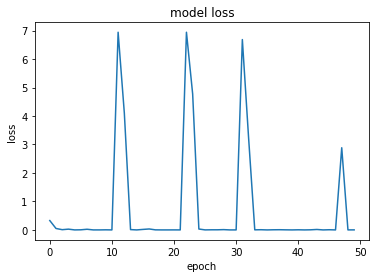

average AUC-ROC: 0.6273, average AUC-PR: 0.5001
STD AUC-ROC: 0.0000, STD AUC-PR: 0.0000
average runtime: 33.6388 seconds


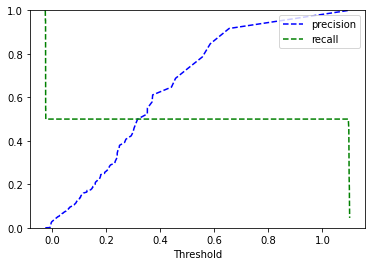

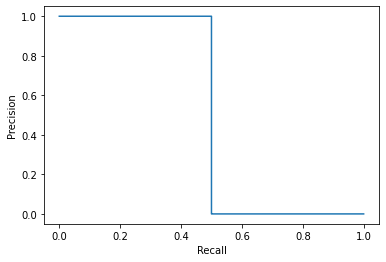

In [20]:
for nm in names:
    runs = runs
    rauc = np.zeros(runs)
    ap = np.zeros(runs)
    filename = nm.strip()
    x, labels = dataLoading()
    print("type x",type(x))
    x_narr = x.drop(['label_global', 'label_local', 'label_regular'], axis = 1)
    print("shape x_narr",x_narr.shape)
    x_narr = x_narr.values
    labels_narr = labels.values 
    outlier_indices = np.where(labels == 1)[0]
    outliers = x_narr[outlier_indices]
    n_outliers_org = outliers.shape[0]

    train_time = 0
    test_time = 0
    for i in np.arange(runs):
        x_train, x_test, y_train, y_test = train_test_split(x, labels, test_size=0.4, random_state=42, stratify=labels)
    
        attacks_train = x_train[['label_global', 'label_local', 'label_regular']]
        
        y_train = np.array(y_train)
        y_test = np.array(y_test)
          
        attack_global_train_pd = x_train['label_global']
        attack_local_train_pd = x_train['label_local']
        attack_regular_train_pd = x_train['label_regular']
        
        attack_global_test_pd = x_test['label_global']
        attack_local_test_pd = x_test['label_local']
        attack_regular_test_pd = x_test['label_regular']

        attack_global_train = np.array(attack_global_train_pd)
        attack_local_train = np.array(attack_local_train_pd)
        attack_regular_train = np.array(attack_regular_train_pd)
        attack_global_test = np.array(attack_global_test_pd)
        attack_local_test = np.array(attack_local_test_pd)
        attack_regular_test = np.array(attack_regular_test_pd)
        
        
        print(filename + ': round ' + str(i))
        outlier_indices = np.where(y_train == 1)[0]
        inlier_indices = np.where(y_train == 0)[0]
        
        outlier_global_indices = np.where(attack_global_train == 1)[0]
        outlier_local_indices = np.where(attack_local_train == 1)[0]
        outlier_regular_indices = np.where(attack_regular_train == 1)[0]
        
        
        outlier_global_indices_test = np.where(attack_global_test == 1)[0]
        outlier_local_indices_test = np.where(attack_local_test == 1)[0]
        outlier_regular_indices_test = np.where(attack_regular_test == 1)[0]
        
        
        n_outlier_global = len(outlier_global_indices) 
        print("global anomalies number ", n_outlier_global)
        
        n_outlier_local = len(outlier_local_indices) 
        print("local anomalies number ", n_outlier_local)
        
        n_outlier_regular = len(outlier_regular_indices) 
        print("regular objects number ", n_outlier_regular)
        
                    
        n_outlier_global_test = len(outlier_global_indices_test) 
        print("global anomaliesnumber test", n_outlier_global_test)
        
        n_outlier_local_test = len(outlier_local_indices_test) 
        print("local anomalies number test", n_outlier_local_test)
        
        n_outlier_regular_test = len(outlier_regular_indices_test) 
        print("regular objects number test", n_outlier_regular_test)
        
        
      
        n_outliers = len(outlier_indices)
        print("Original training size: %d, No. outliers: %d" % (x_train.shape[0], n_outliers))
        
        
        x_train = x_train.drop(['label_global', 'label_local', 'label_regular'], axis = 1)
        x_test = x_test.drop(['label_global', 'label_local', 'label_regular'], axis = 1)
        
        x_train = x_train.values
        x_test = x_test.values
      
        rng = np.random.RandomState(random_seed)
        
        
        if n_outliers > known_outliers:
            
            #mn_global = n_outlier_global
            mn_global = n_outlier_global - known_outliers
            remove_idx_global = rng.choice(outlier_global_indices,  mn_global, replace=False)
            final_outlier_global = n_outlier_global- len(remove_idx_global)
            print("global anomalies", final_outlier_global)
            
            mn_local = n_outlier_local 
            #mn_local = n_outlier_local - known_outliers 
            remove_idx_local = rng.choice(outlier_local_indices,  mn_local, replace=False)
            final_outlier_local = n_outlier_local - len(remove_idx_local)
            print("local anomalies", final_outlier_local)
         
            remove_idx = np.concatenate([remove_idx_global,remove_idx_local])
            
            x_train = np.delete(x_train, remove_idx, axis=0)
            y_train = np.delete(y_train, remove_idx, axis=0)
            
            attack_global_train = np.delete(attack_global_train, remove_idx, axis=0)
            attack_local_train = np.delete(attack_local_train, remove_idx, axis=0)
            attack_regular_train = np.delete(attack_regular_train, remove_idx, axis=0)
            
            #mn_global_test = n_outlier_global_test
            mn_global_test = n_outlier_global_test - 11
            remove_idx_global_test = rng.choice(outlier_global_indices_test,  mn_global_test, replace=False)
            final_outlier_global_test = n_outlier_global_test - len(remove_idx_global_test)
            print("global anomalies validation", final_outlier_global_test)
            
            #mn_local_test = n_outlier_local_test
            mn_local_test = n_outlier_local_test - 11
            remove_idx_local_test = rng.choice(outlier_local_indices_test,  mn_local_test, replace=False)
            final_outlier_local_test = n_outlier_local_test - len(remove_idx_local_test)
            print("local anomalies validation", final_outlier_local_test)
           
            remove_idx_test = np.concatenate([remove_idx_global_test,remove_idx_local_test])
            
            x_test = np.delete(x_test, remove_idx_test, axis=0)
            y_test = np.delete(y_test, remove_idx_test, axis=0)    
      
        outlier_indices = np.where(y_train == 1)[0]
        inlier_indices = np.where(y_train == 0)[0]
      
        outlier_global_indices = np.where(attack_global_train == 1)[0]
        
        outlier_local_indices = np.where(attack_local_train == 1)[0]
        
        outlier_regular_indices = np.where(attack_regular_train == 1)[0]
        
        print('training samples num:', y_train.shape[0],
              'outlier num:', outlier_indices.shape[0],
              'inlier num:', inlier_indices.shape[0])
        print('training samples num:', y_train.shape[0],
              'outlier num:', outlier_indices.shape[0],
              'inlier num:', inlier_indices.shape[0])
        n_samples_trn = x_train.shape[0]
        n_outliers = len(outlier_indices)
        print("Training data size: %d, No. outliers: %d" % (x_train.shape[0], n_outliers))

        start_time = time.time()
        input_shape = x_train.shape[1:]
        print('input_shape', input_shape)
        
        print('x_train shape', x_train.shape)
        print('x_test shape', x_test.shape)
        print('y_train shape', y_train.shape)
        print('y_test shape', y_test.shape)
        
        epochs = epochs
        batch_size = batch_size
        nb_batch = nb_batch

        model = deviation_network(input_shape, network_depth)
        print(model.summary())
        model_filename= filename + "_" +  str(batch_size) +"bs_" + str(known_outliers) + "ko_" + str(network_depth) +"d.h5" 
        model_name = os.path.join('../model', model_filename)
        checkpointer = ModelCheckpoint(filepath=model_name, monitor='loss', verbose=0,
                                        save_best_only=True, save_weights_only=True)

        model.fit_generator(
            batch_generator_sup(x_train, outlier_indices, inlier_indices, outlier_global_indices, outlier_local_indices, outlier_regular_indices, batch_size, nb_batch, rng),
            steps_per_epoch=nb_batch,
            epochs=epochs,
            callbacks=[checkpointer])
        train_time += time.time() - start_time

        start_time = time.time()
        scores = load_model_weight_predict(model_name, input_shape, network_depth, x_test)
        test_time += time.time() - start_time
        rauc[i], ap[i] = aucPerformance_norm(scores, y_test)
        
        preds = scores
        
        class_one = preds > 0.5
        predic_class = np.where(class_one == True,1,0)
        
        precision_new = precision_score(y_test, predic_class)
        print('new precision',precision_new)
        recall_new = recall_score(y_test, predic_class)
        print('new recall',recall_new)
        f1_new = 2 * ((precision_new * recall_new) / (precision_new + recall_new ))
        print('f1 new',f1_new)
        precision, recall, thresh = precision_recall_curve(y_test, scores)

        fig3 = plt.figure()
        plt.plot(model.history.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        #plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
        fig3.savefig('my_figure3.png')
        

    mean_auc = np.mean(rauc)
    std_auc = np.std(rauc)
    mean_aucpr = np.mean(ap)
    std_aucpr = np.std(ap)
    train_time = train_time / runs
    test_time = test_time / runs
    
    print("average AUC-ROC: %.4f, average AUC-PR: %.4f" % (mean_auc, mean_aucpr))
    print("STD AUC-ROC: %.4f, STD AUC-PR: %.4f" % (std_auc,  std_aucpr))
    print("average runtime: %.4f seconds" % (train_time + test_time))
    
    fig = plt.figure()
    plt.plot(thresh, precision[:-1], 'b--', label='precision')
    plt.plot(thresh, recall[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper right')
    plt.ylim([0,1])
    #pyplot.show()
    fig.savefig('my_figure.png')
    
    fig2 = plt.figure()
    
    plt.plot(recall, precision)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    #plt.legend(loc="upper right")
    # show the plot
    fig2.savefig('my_figure2.png')
    


Knowing local anomalies

In [21]:
def batch_generator_sup(x, outlier_indices, inlier_indices, outlier_analysis_indices, outlier_backdoor_indices, outlier_dos_indices, batch_size, nb_batch, rng):
    """batch generator
    """
    rng = np.random.RandomState(rng.randint(MAX_INT, size=1))
    counter = 0
    while 1:
        #ref, training_labels = input_batch_generation_weaklyonlyone_knowingglobal(x, outlier_indices, inlier_indices, outlier_global_indices, outlier_local_indices, outlier_regular_indices, batch_size, rng)
        ref, training_labels = input_batch_generation_weaklyonlyone_knowinglocal(x, outlier_indices, inlier_indices, outlier_global_indices, outlier_local_indices, outlier_regular_indices, batch_size, rng)
        counter += 1
        yield (ref, training_labels)
        if (counter > nb_batch):
            counter = 0

In [22]:
names = ['ori_subset_transformed_621']
network_depth = 2
random_seed = 42
batch_size = 64
nb_batch = 30
epochs = 50
runs = 1
known_outliers = 10
input_path = '../dataset'

Data shape: (533009, 621)
type x <class 'pandas.core.frame.DataFrame'>
shape x_narr (533009, 618)
ori_subset_transformed_621: round 0
global anomalies number  41
local anomalies number  19
regular objects number  319745
global anomaliesnumber test 29
local anomalies number test 11
regular objects number test 213164
Original training size: 319805, No. outliers: 60
global anomalies 0
local anomalies 10
global anomalies validation 4
local anomalies validation 4
training samples num: 319755 outlier num: 10 inlier num: 319745
training samples num: 319755 outlier num: 10 inlier num: 319745
Training data size: 319755, No. outliers: 10
input_shape (618,)
x_train shape (319755, 618)
x_test shape (213172, 618)
y_train shape (319755, 1)
y_test shape (213172, 1)
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 618)]             0         
________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


30/30 [==============================] - 1s 18ms/step - loss: 0.7145
Epoch 2/50
30/30 [==============================] - 1s 17ms/step - loss: 0.1526
Epoch 3/50
30/30 [==============================] - 1s 18ms/step - loss: 0.0662
Epoch 4/50
30/30 [==============================] - 0s 17ms/step - loss: 0.0394
Epoch 5/50
30/30 [==============================] - 1s 17ms/step - loss: 0.0309
Epoch 6/50
30/30 [==============================] - 1s 17ms/step - loss: 0.0276
Epoch 7/50
30/30 [==============================] - 0s 17ms/step - loss: 0.0266
Epoch 8/50
30/30 [==============================] - 1s 17ms/step - loss: 0.0256
Epoch 9/50
30/30 [==============================] - 0s 17ms/step - loss: 0.0244
Epoch 10/50
30/30 [==============================] - 1s 18ms/step - loss: 0.0235
Epoch 11/50
30/30 [==============================] - 0s 16ms/step - loss: 0.0225
Epoch 12/50
30/30 [==============================] - 1s 17ms/step - loss: 0.0242
Epoch 13/50
30/30 [=============================

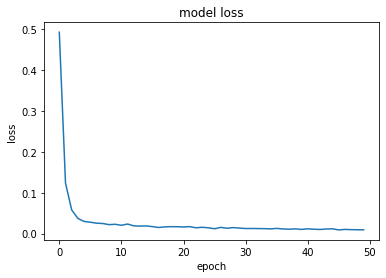

average AUC-ROC: 0.5000, average AUC-PR: 0.5000
STD AUC-ROC: 0.0000, STD AUC-PR: 0.0000
average runtime: 34.8180 seconds


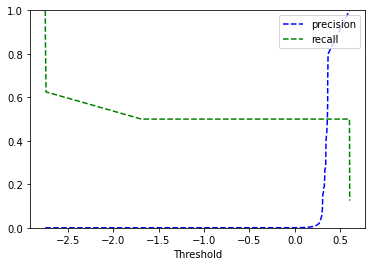

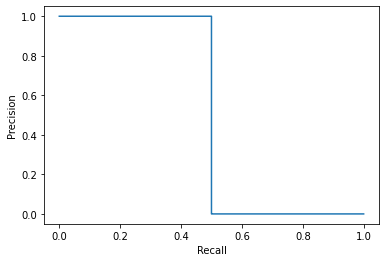

In [26]:
for nm in names:
    runs = runs
    rauc = np.zeros(runs)
    ap = np.zeros(runs)
    filename = nm.strip()
    x, labels = dataLoading()
    print("type x",type(x))
    x_narr = x.drop(['label_global', 'label_local', 'label_regular'], axis = 1)
    print("shape x_narr",x_narr.shape)
    x_narr = x_narr.values
    labels_narr = labels.values 
    outlier_indices = np.where(labels == 1)[0]
    outliers = x_narr[outlier_indices]
    n_outliers_org = outliers.shape[0]

    train_time = 0
    test_time = 0
    for i in np.arange(runs):
        x_train, x_test, y_train, y_test = train_test_split(x, labels, test_size=0.4, random_state=42, stratify=labels)
    
        attacks_train = x_train[['label_global', 'label_local', 'label_regular']]
        
        y_train = np.array(y_train)
        y_test = np.array(y_test)
          
        attack_global_train_pd = x_train['label_global']
        attack_local_train_pd = x_train['label_local']
        attack_regular_train_pd = x_train['label_regular']
        
        attack_global_test_pd = x_test['label_global']
        attack_local_test_pd = x_test['label_local']
        attack_regular_test_pd = x_test['label_regular']

        attack_global_train = np.array(attack_global_train_pd)
        attack_local_train = np.array(attack_local_train_pd)
        attack_regular_train = np.array(attack_regular_train_pd)
          
        attack_global_test = np.array(attack_global_test_pd)
        attack_local_test = np.array(attack_local_test_pd)
        attack_regular_test = np.array(attack_regular_test_pd)
        
        
        print(filename + ': round ' + str(i))
        outlier_indices = np.where(y_train == 1)[0]
        inlier_indices = np.where(y_train == 0)[0]
        
        outlier_global_indices = np.where(attack_global_train == 1)[0]
        outlier_local_indices = np.where(attack_local_train == 1)[0]
        outlier_regular_indices = np.where(attack_regular_train == 1)[0]
        
        
        outlier_global_indices_test = np.where(attack_global_test == 1)[0]
        outlier_local_indices_test = np.where(attack_local_test == 1)[0]
        outlier_regular_indices_test = np.where(attack_regular_test == 1)[0]
        
        
        n_outlier_global = len(outlier_global_indices) 
        print("global anomalies number ", n_outlier_global)
        
        n_outlier_local = len(outlier_local_indices) 
        print("local anomalies number ", n_outlier_local)
        
        n_outlier_regular = len(outlier_regular_indices) 
        print("regular objects number ", n_outlier_regular)
        
                    
        n_outlier_global_test = len(outlier_global_indices_test) 
        print("global anomaliesnumber test", n_outlier_global_test)
        
        n_outlier_local_test = len(outlier_local_indices_test) 
        print("local anomalies number test", n_outlier_local_test)
        
        n_outlier_regular_test = len(outlier_regular_indices_test) 
        print("regular objects number test", n_outlier_regular_test)
        
        
      
        n_outliers = len(outlier_indices)
        print("Original training size: %d, No. outliers: %d" % (x_train.shape[0], n_outliers))
        
        
        x_train = x_train.drop(['label_global', 'label_local', 'label_regular'], axis = 1)
        x_test = x_test.drop(['label_global', 'label_local', 'label_regular'], axis = 1)
        
        x_train = x_train.values
        x_test = x_test.values
      

        rng = np.random.RandomState(random_seed)
        
        if n_outliers > known_outliers:
            
            mn_global = n_outlier_global
            #mn_global = n_outlier_global - known_outliers
            remove_idx_global = rng.choice(outlier_global_indices,  mn_global, replace=False)
            #print("remove_idx_analysis",remove_idx_analysis)
            final_outlier_global = n_outlier_global- len(remove_idx_global)
            print("global anomalies", final_outlier_global)
            
            #mn_local = n_outlier_local 
            mn_local = n_outlier_local - known_outliers 
            remove_idx_local = rng.choice(outlier_local_indices,  mn_local, replace=False)
            final_outlier_local = n_outlier_local - len(remove_idx_local)
            print("local anomalies", final_outlier_local)
                  
            remove_idx = np.concatenate([remove_idx_global,remove_idx_local])
            
            x_train = np.delete(x_train, remove_idx, axis=0)
            y_train = np.delete(y_train, remove_idx, axis=0)
            
            attack_global_train = np.delete(attack_global_train, remove_idx, axis=0)
            attack_local_train = np.delete(attack_local_train, remove_idx, axis=0)
            attack_regular_train = np.delete(attack_regular_train, remove_idx, axis=0)
            
            #mn_global_test = n_outlier_global_test
            mn_global_test = n_outlier_global_test - 4
            remove_idx_global_test = rng.choice(outlier_global_indices_test,  mn_global_test, replace=False)
            final_outlier_global_test = n_outlier_global_test - len(remove_idx_global_test)
            print("global anomalies validation", final_outlier_global_test)
            
            #mn_local_test = n_outlier_local_test
            mn_local_test = n_outlier_local_test - 4
            remove_idx_local_test = rng.choice(outlier_local_indices_test,  mn_local_test, replace=False)
            final_outlier_local_test = n_outlier_local_test - len(remove_idx_local_test)
            print("local anomalies validation", final_outlier_local_test)
                  
            remove_idx_test = np.concatenate([remove_idx_global_test,remove_idx_local_test])
            
            x_test = np.delete(x_test, remove_idx_test, axis=0)
            y_test = np.delete(y_test, remove_idx_test, axis=0)    
      
        outlier_indices = np.where(y_train == 1)[0]
        inlier_indices = np.where(y_train == 0)[0]
      
        outlier_global_indices = np.where(attack_global_train == 1)[0]
        
        outlier_local_indices = np.where(attack_local_train == 1)[0]
        
        outlier_regular_indices = np.where(attack_regular_train == 1)[0]
        
        print('training samples num:', y_train.shape[0],
              'outlier num:', outlier_indices.shape[0],
              'inlier num:', inlier_indices.shape[0])
        print('training samples num:', y_train.shape[0],
              'outlier num:', outlier_indices.shape[0],
              'inlier num:', inlier_indices.shape[0])
        n_samples_trn = x_train.shape[0]
        n_outliers = len(outlier_indices)
        print("Training data size: %d, No. outliers: %d" % (x_train.shape[0], n_outliers))

        start_time = time.time()
        input_shape = x_train.shape[1:]
        print('input_shape', input_shape)
        
        print('x_train shape', x_train.shape)
        print('x_test shape', x_test.shape)
        print('y_train shape', y_train.shape)
        print('y_test shape', y_test.shape)
        
        epochs = epochs
        batch_size = batch_size
        nb_batch = nb_batch

        model = deviation_network(input_shape, network_depth)
        print(model.summary())
        model_filename= filename + "_" + "cr_"  + str(batch_size) +"bs_" + str(known_outliers) + "ko_" + str(network_depth) +"d.h5" 
        model_name = os.path.join('../model', model_filename)
        checkpointer = ModelCheckpoint(filepath=model_name, monitor='loss', verbose=0,
                                        save_best_only=True, save_weights_only=True)

        model.fit_generator(
            batch_generator_sup(x_train, outlier_indices, inlier_indices, outlier_global_indices, outlier_local_indices, outlier_regular_indices, batch_size, nb_batch, rng),
            steps_per_epoch=nb_batch,
            epochs=epochs,
            callbacks=[checkpointer])
        train_time += time.time() - start_time

        start_time = time.time()
        scores = load_model_weight_predict(model_name, input_shape, network_depth, x_test)
        test_time += time.time() - start_time
        rauc[i], ap[i] = aucPerformance_norm(scores, y_test)
        
        preds = scores
        
        class_one = preds > 0.5
        predic_class = np.where(class_one == True,1,0)
        
        precision_new = precision_score(y_test, predic_class)
        print('new precision',precision_new)
        recall_new = recall_score(y_test, predic_class)
        print('new recall',recall_new)
        f1_new = 2 * ((precision_new * recall_new) / (precision_new + recall_new ))
        print('f1 new',f1_new)
        precision, recall, thresh = precision_recall_curve(y_test, scores)

        fig3 = plt.figure()
        plt.plot(model.history.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        #plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
        fig3.savefig('my_figure3.png')
        

    mean_auc = np.mean(rauc)
    std_auc = np.std(rauc)
    mean_aucpr = np.mean(ap)
    std_aucpr = np.std(ap)
    train_time = train_time / runs
    test_time = test_time / runs
    
    print("average AUC-ROC: %.4f, average AUC-PR: %.4f" % (mean_auc, mean_aucpr))
    print("STD AUC-ROC: %.4f, STD AUC-PR: %.4f" % (std_auc,  std_aucpr))
    print("average runtime: %.4f seconds" % (train_time + test_time))
    
    fig = plt.figure()
    plt.plot(thresh, precision[:-1], 'b--', label='precision')
    plt.plot(thresh, recall[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper right')
    plt.ylim([0,1])
    #pyplot.show()
    fig.savefig('my_figure.png')
    
    fig2 = plt.figure()
    
    plt.plot(recall, precision)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    #plt.legend(loc="upper right")
    # show the plot
    fig2.savefig('my_figure2.png')
    